In [433]:
import pandas as pd
import numpy as np
from scipy import stats

from mplsoccer import Sbopen, PyPizza

import matplotlib.pyplot as plt
from matplotlib.text import Text
from matplotlib.patches import Rectangle, Circle
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
import matplotlib.image as mpimg

parser = Sbopen()

# Combine all matches in one dataframe

In [434]:
def get_all_match_ids(competition_id, season_id):
    """
    Get all match ids for a given competition and season.

    Parameters
    ----------
    competition_id: int
        The id of the competition
    season_id: int
        The id of the season

    Returns
    -------
    match_ids: list
        A list of all match ids for a given competition and season
    """
    df_all_matches = parser.match(competition_id=competition_id, season_id=season_id)
    match_ids = df_all_matches['match_id'].tolist()
    
    return match_ids

In [435]:
# Example usage
match_ids = get_all_match_ids(competition_id=55, season_id=282)

In [436]:
match_ids[0:10]

[3942819,
 3943043,
 3942752,
 3942382,
 3942349,
 3930180,
 3930171,
 3942227,
 3942226,
 3938645]

In [437]:

def load_all_events(match_ids):
    """
    Combine all events for all matches for a given competition and season.

    Parameters
    ----------
    match_ids: list
        A list of all match ids for a given competition and season

    Returns
    -------
    df_all_events: pd.DataFrame
        A dataframe with all Statsbomb event data for all matches of a given competition and season
    """
    
    # Init empty list to store all events
    all_events = []

    # Loop through all matches
    for match_id in match_ids:
        df_match = parser.event(match_id)[0]
        all_events.append(df_match)

    # Concatenate all events
    df_all_events = pd.concat(all_events, ignore_index=True)

    return df_all_events

In [438]:
# Example usage load all events
df_all_events = load_all_events(match_ids)

In [439]:
df_all_events.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 187858 entries, 0 to 187857
Data columns (total 87 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   id                              187858 non-null  object 
 1   index                           187858 non-null  int64  
 2   period                          187858 non-null  int64  
 3   timestamp                       187858 non-null  object 
 4   minute                          187858 non-null  int64  
 5   second                          187858 non-null  int64  
 6   possession                      187858 non-null  int64  
 7   duration                        136240 non-null  float64
 8   match_id                        187858 non-null  int64  
 9   type_id                         187858 non-null  int64  
 10  type_name                       187858 non-null  object 
 11  possession_team_id              187858 non-null  int64  
 12  possession_team_

# Calculate playing time

To calculate the playing time of a player (per game) we need a couple of things: how long each period was, how long the game was, when the player got subbed on or off and when a player left the game with a red card.

In [440]:
def calculate_period_lengths(df):
    """ 
    Get the length of each period in a game.

    Parameters
    ----------
    df: pd.DataFrame
        Dataframe with Statsbomb event data for a certain game.

    Returns
    -------
    df_periods: pd.DataFrame
        Dataframe with the length of each period in a game.
    """
    df_end = df.loc[df['type_name'] == 'Half End', ['period', 'timestamp', 'minute', 'second', 'type_name', 'team_name']]
    df_periods = pd.DataFrame(columns=['period', 'length', 'additional_time', 'minutes_played', 'seconds_played', 'game_minute', 'game_second'])

    # Only check for first half, second half and extra time but not for penalties
    for period, total_length in [(1, 45), (2, 90), (3, 105), (4, 120)]:
        if period in df_end['period'].values:
            df_end_period = df_end.loc[df_end['period'] == period, ['timestamp', 'minute', 'second']].iloc[0]

            # Get played time of this period in minutes and seconds
            df_end_period['minutes_length'] = df_end_period['timestamp'].hour * 60 + df_end_period['timestamp'].minute
            df_end_period['seconds_length'] = df_end_period['timestamp'].second
            
            # Get period length and additional time in seconds
            period_length = df_end_period['minutes_length'] * 60 + df_end_period['seconds_length']
            period_additional_time = (df_end_period['minute'] * 60) + df_end_period['second'] - (total_length * 60)

            df_periods = pd.concat([
                df_periods,
                pd.DataFrame([{
                    'period': period,
                    'length': period_length,
                    'additional_time': period_additional_time,
                    'minutes_played': df_end_period['minutes_length'],
                    'seconds_played': df_end_period['seconds_length'],
                    'game_minute': df_end_period['minute'],
                    'game_second': df_end_period['second']
                }])
            ], ignore_index=True)
    return df_periods.reset_index(drop=True)

In [441]:
# Example usage
test_game = parser.event(3942227)[0]
df_example = calculate_period_lengths(test_game)
df_example.head()

,period,length,additional_time,minutes_played,seconds_played,game_minute,game_second
0,1,2706,6,45,6,45,6
1,2,2876,176,47,56,92,56
2,3,900,0,15,0,105,0
3,4,967,67,16,7,121,7


In [442]:
def get_substitution_events(df):
    """
    Get the substitution events for a given game.

    Parameters
    ----------
    df: pd.DataFrame
        Dataframe with Statsbomb event data for a certain game.

    Returns
    -------
    df_subs: pd.DataFrame
        Dataframe with the substitution events for a given game.
    """
    subs_mask = (df['type_name'] == 'Substitution')
    subs_columns = ['match_id', 'period', 'minute', 'second', 'type_name', 'team_name', 'player_id', 'substitution_replacement_id']
    df_subs = df.loc[subs_mask, subs_columns]
    
    # Rename the columns to be more descriptive about the substitution
    df_subs.rename(columns={
        'player_id': 'player_off',
        'substitution_replacement_id': 'player_on'
    }, inplace=True)

    # Add column for substitution time
    df_subs['sub_time'] = df_subs['minute'] * 60 + df_subs['second']
    
    return df_subs.reset_index(drop=True)

In [443]:
# Example usage
df_example = get_substitution_events(test_game)
df_example.head()

,match_id,period,minute,second,type_name,team_name,player_off,player_on,sub_time
0,3942227,2,62,53,Substitution,Switzerland,50436.0,5548.0,3773
1,3942227,2,63,0,Substitution,Switzerland,30401.0,7796.0,3780
2,3942227,2,77,18,Substitution,England,99174.0,3382.0,4638
3,3942227,2,77,23,Substitution,England,3308.0,9000.0,4643
4,3942227,2,78,26,Substitution,England,3822.0,39461.0,4706


In [444]:
def get_red_card_events(df):
    """
    Get the red card events for a given game.

    Parameters
    ----------
    df: pd.DataFrame
        Dataframe with Statsbomb event data for a certain game.

    Returns
    -------
    df_cards: pd.DataFrame
        Dataframe with the red card events for a given game.
    """
    red_card_names = ['Red Card', 'Second Yellow']

    # Init mask
    cards_mask = pd.Series(False, index=df.index)

    # Check each column if it exists and update mask
    if 'foul_committed_card_name' in df.columns:
        cards_mask = cards_mask | df['foul_committed_card_name'].isin(red_card_names)
    
    if 'bad_behaviour_card_name' in df.columns:
        cards_mask = cards_mask | df['bad_behaviour_card_name'].isin(red_card_names)
    
    # Add card columns that exist
    card_columns = ['match_id', 'period', 'minute', 'second', 'type_name', 'team_name', 'player_id']
    if 'foul_committed_card_name' in df.columns:
        card_columns.append('foul_committed_card_name')
    if 'bad_behaviour_card_name' in df.columns:
        card_columns.append('bad_behaviour_card_name')

    # Get cards
    df_cards = df[cards_mask][card_columns]
    
    # Add column for card time
    df_cards['red_card_time'] = df_cards['minute'] * 60 + df_cards['second']
    
    return df_cards.reset_index(drop=True)

In [445]:
# Example usage
red_card_match_id = 3942382
df_red_card_game = parser.event(red_card_match_id)[0]
df_example = get_red_card_events(df_red_card_game)
df_example.head()

,match_id,period,minute,second,type_name,team_name,player_id,foul_committed_card_name,bad_behaviour_card_name,red_card_time
0,3942382,2,95,21,Bad Behaviour,Turkey,133168.0,NaN,Red Card,5721


In [446]:
def calculate_playing_time_single_match(df):
    """ 
    Calculate the playing time (in seconds) of a player in a game.

    Parameters
    ----------
    df: pd.DataFrame
        Dataframe with Statsbomb event data for a certain game.

    Returns
    -------
    df_playing_time: pd.DataFrame
        Dataframe with the playing time of a player in a game.
    """

    # Get period lengths and total game time
    df_periods = calculate_period_lengths(df)
    full_game_time = df_periods['length'].sum()

    # Get substitution events
    df_subs = get_substitution_events(df)

    # Get red card events
    df_reds = get_red_card_events(df)

    # Get players who played in the game and init their playing time
    df_players = df[['match_id', 'player_id']].drop_duplicates().dropna()    # dropna() because some events are not linked to players
    df_players['playing_time'] = full_game_time

    # Adapt playing time for players who were substituted
    for i, player in df_players.iterrows():
        player_id = player['player_id']
        player_playing_time = player['playing_time']
        
        # If player came on, how much time did they miss from the start of the game?
        if player_id in df_subs['player_on'].values:
            sub_on = df_subs[df_subs['player_on'] == player_id]
            period = sub_on['period'].iloc[0]
            missed_playing_time = sub_on['sub_time'].iloc[0]

            # loop through df_periods to add extra time to missed_playing_time from all periods before the sub
            for i, row in df_periods.iterrows():
                if row['period'] < period:
                    missed_playing_time += row['additional_time']
                else:
                    break

            total_playing_time = player_playing_time - missed_playing_time
            
            df_players.loc[df_players['player_id'] == player_id, 'playing_time'] = total_playing_time
        
        # If player came off, how much time did they miss to the end of the game?
        if player_id in df_subs['player_off'].values:
            sub_off = df_subs[df_subs['player_off'] == player_id]
            period = sub_off['period'].iloc[0]
            playing_time_before_sub = sub_off['sub_time'].iloc[0]

            missed_playing_time = full_game_time - playing_time_before_sub

            # loop through df_periods to add extra time to missed_playing_time from all periods after the sub
            for i, row in df_periods.iterrows():
                if row['period'] >= period and row['period'] < 4:
                    missed_playing_time += row['additional_time']
                else:
                    continue
            
            total_playing_time = player_playing_time - missed_playing_time
            
            df_players.loc[df_players['player_id'] == player_id, 'playing_time'] = total_playing_time
        
        # If player came off with a red card, how much time did they miss to the end of the game?
        if player_id in df_reds['player_id'].values:
            red_card_off = df_reds[df_reds['player_id'] == player_id]
            period = red_card_off['period'].iloc[0]
            playing_time_before_red_card = red_card_off['red_card_time'].iloc[0]
            missed_playing_time = full_game_time - playing_time_before_red_card

            # loop through df_periods to add extra time to missed_playing_time from all periods after the red card
            for i, row in df_periods.iterrows():
                if row['period'] >= period and row['period'] < 4:
                    missed_playing_time += row['additional_time']
                else:
                    continue
            
            total_playing_time = player_playing_time - missed_playing_time
            
            df_players.loc[df_players['player_id'] == player_id, 'playing_time'] = total_playing_time

    return df_players.reset_index(drop=True)

In [447]:
# Get playing time
df_playing_time = calculate_playing_time_single_match(test_game)
df_playing_time.head()

,match_id,player_id,playing_time
0,3942227,99174.0,4462
1,3942227,3468.0,7449
2,3942227,5544.0,7449
3,3942227,5550.0,7449
4,3942227,30714.0,7449


In [448]:
def calculate_playing_time(match_ids, df):
    """
    Calculate the playing time (in seconds) of players for the whole season.

    Parameters
    ----------
    match_ids: list
        A list of match ids to calculate the playing time for.
    df: pd.DataFrame
        A dataframe with all Statsbomb event data for all matches of a given competition and season.

    Returns
    -------
    df_playing_time: pd.DataFrame
        A dataframe with the playing time of players for the whole season.
    """

    # Init empty list for playing time dataframes
    playing_time_list = []

    # Loop through all matches and calculate the playing time for each player
    for match_id in match_ids:
        df_match = df[df['match_id'] == match_id]
        df_playing_time_match = calculate_playing_time_single_match(df_match)
        playing_time_list.append(df_playing_time_match)

    df_playing_time = pd.concat(playing_time_list)

    # Group by player_id and sum the playing time
    df_playing_time = df_playing_time.groupby('player_id').sum().reset_index()

    # Drop match_id column
    df_playing_time = df_playing_time.drop(columns=['match_id'])

    return df_playing_time

In [449]:
# Example usage
df_example = calculate_playing_time(match_ids, df_all_events)
df_example.sort_values(by='playing_time', ascending=False).head()

,player_id,playing_time
15,3205.0,44201
44,3943.0,44201
24,3468.0,44201
16,3244.0,44201
348,30714.0,41596


# Calculate goals and assists

In [450]:
def calculate_goals_assists(df):
    """
    Calculate the number of goals and assists for each player.

    Parameters
    ----------
    df: pd.DataFrame
        A dataframe with all Statsbomb event data for all matches of a given competition and season.

    Returns
    -------
    df: pd.DataFrame
        A dataframe with the number of goals and assists for each player.
    """

    # Filter for goals
    goals_mask = ((df["outcome_id"] == 97) & (df["period"] != 5))       # goal id is 97, don't count penalties, own goals don't have a outcome_id
    df_goals = df.loc[goals_mask, ["player_id"]].copy()
    df_goals_count = df_goals.groupby("player_id").size().reset_index(name="goals")

    # Filter for assists
    assists_mask = (df["pass_goal_assist"] == True)
    df_assists = df.loc[assists_mask, ["player_id"]].copy()

    # Count assists per player
    df_assists_count = df_assists.groupby("player_id").size().reset_index(name="assists")

    # Merge goals and assists
    df_goals_assists = pd.merge(df_goals_count, df_assists_count, on="player_id", how="outer")

    # Fill missing values with 0
    df_goals_assists["goals"] = df_goals_assists["goals"].fillna(0)
    df_goals_assists["assists"] = df_goals_assists["assists"].fillna(0)

    # Set goals and assists to int
    df_goals_assists["goals"] = df_goals_assists["goals"].astype(int)
    df_goals_assists["assists"] = df_goals_assists["assists"].astype(int)

    return df_goals_assists

In [451]:
# Example usage
df_example = calculate_goals_assists(df_all_events)

In [452]:
df_example.sort_values(by="goals", ascending=False).head(10)

,player_id,goals,assists
98,33234.0,3,1
62,10955.0,3,0
74,16532.0,3,2
78,20750.0,3,1
89,28032.0,3,0
103,39565.0,3,0
24,5545.0,2,0
54,8966.0,2,1
70,15582.0,2,0
73,16344.0,2,0


# Calculate shots and total xG

In [453]:
def calculate_shots_xg(df):
    """
    Calculate number of shots and total xG.

    Parameters
    ----------
    df: pd.DataFrame
        A dataframe with all Statsbomb event data for all matches of a given competition and season.

    Returns
    -------
    df_xg_shots: pd.DataFrame
        Dataframe with xG from shots for players in a game.
    """
    
    # Filter for shots
    shots_mask = (df['type_name'] == 'Shot')
    df_shots = df.loc[shots_mask, ['player_id', 'type_name', 'shot_statsbomb_xg']].copy()
    df_shots.rename(columns={'shot_statsbomb_xg': 'shots_xg'}, inplace=True)

    # Group by player and count shots and sum xG
    df_xg_shots = df_shots.groupby('player_id').agg({'type_name': 'count', 'shots_xg': 'sum'}).reset_index()
    df_xg_shots.rename(columns={'type_name': 'shots'}, inplace=True)

    return df_xg_shots

In [454]:
# Usage example
df_example = calculate_shots_xg(df_all_events)
df_example.head(10)

,player_id,shots,shots_xg
0,2954.0,4,0.153319
1,2972.0,12,1.178654
2,2988.0,18,1.951101
3,3009.0,24,2.506847
4,3026.0,3,0.262040
5,3042.0,3,0.326048
6,3043.0,12,0.835043
7,3053.0,7,0.282124
8,3076.0,3,0.323953
9,3077.0,1,0.104913


# Calculate dribbles

Completed, failed, total dribbles and success rate

In [455]:
def calculate_dribbles(df):
    """
    Calculate the number of dribbles for a player in a game.

    Parameters
    ----------
    df: pd.DataFrame
        A dataframe with all Statsbomb event data for all matches of a given competition and season.

    Returns
    -------
    df_dribbles: pd.DataFrame
        A dataframe with the dribbles for each player: completed, failed and total dribbles.
    """
    
    # Filter for dribbles
    dribbles_mask = (df['type_name'] == 'Dribble')
    df_dribbles = df.loc[dribbles_mask, ['player_id', 'type_name', 'outcome_name']].copy()

    # Count dribbles per player
    df_dribble_stats = (df_dribbles
                        .groupby(['player_id', 'outcome_name'])
                        .size()
                        .unstack(fill_value=0))
    
    df_dribble_stats = df_dribble_stats.rename(columns={
        'Complete': 'completed_dribbles', 
        'Incomplete': 'failed_dribbles'
    })

    # Calculate total dribbles
    df_dribble_stats['attempted_dribbles'] = df_dribble_stats['completed_dribbles'] + df_dribble_stats['failed_dribbles']

    # Calculate success rate
    df_dribble_stats['dribble_success_rate'] = df_dribble_stats['completed_dribbles'] / df_dribble_stats['attempted_dribbles']

    return df_dribble_stats.reset_index()

In [456]:
# Example usage
df_example = calculate_dribbles(df_all_events)
df_example.head()

outcome_name,player_id,completed_dribbles,failed_dribbles,attempted_dribbles,dribble_success_rate
0,2972.0,1,2,3,0.333333
1,2988.0,5,6,11,0.454545
2,3009.0,18,10,28,0.642857
3,3026.0,4,1,5,0.800000
4,3042.0,1,1,2,0.500000


# Calculate danger dribbles and created xG

Danger dribbles end in a shot on goal within a certain timeframe (for example 15 seconds)

In [457]:
def calculate_danger_dribbles_single_match(df, shot_window=15):
    """
    Calculate the danger dribbles of players and the xG that came from them for a single match.

    Parameters
    ----------
    df: pd.DataFrame
        A dataframe with all Statsbomb event data for a single match.

    Returns
    -------
    df_danger_dribbles: pd.DataFrame
        A dataframe with the danger dribbles of players and the xG that came from them for a single match.
    """
    
    # Init danger dribbles list
    danger_dribbles = []

    # Period start times in seconds
    period_starts = {
        1: 0,          # First half: start at 0:00
        2: 45 * 60,    # Second half: start at 45:00
        3: 90 * 60,    # First ET: start at 90:00
        4: 105 * 60    # Second ET: start at 105:00
    }

    # Relevant columns
    relevant_columns = [
        "match_id", "period", "minute", "second", "type_name", "team_name", "player_id", "outcome_name", "x", "y", "shot_statsbomb_xg"
    ]

    # Iterate through periods
    for period in [1, 2, 3, 4]:
        # Get succesful dribbles
        dribbles_mask = (
            (df["type_name"] == "Dribble") &
            (df["period"] == period) &
            (df["outcome_name"] == "Complete")
        )
        
        dribbles_df = df.loc[dribbles_mask, relevant_columns]

        if dribbles_df.empty:
            continue

        # Get shots
        shots_mask = (
            (df["type_name"] == "Shot") &
            (df["period"] == period)
        )

        shots_df = df.loc[shots_mask, relevant_columns]

        if shots_df.empty:
            continue

        # Find dribbles within the shot window
        dangerous_dribbles = []
        for _, dribble in dribbles_df.iterrows():
            dribble_time = dribble['minute'] * 60 + dribble['second']
            dribble_team = dribble['team_name']

            # Filter shots by team
            df_team_shots = shots_df[shots_df['team_name'] == dribble_team]

            if df_team_shots.empty:
                continue

            # Calculate shot window
            team_shots_times = df_team_shots["minute"] * 60 + df_team_shots["second"]
            team_shots_start = team_shots_times - shot_window
            team_shots_start = np.maximum(team_shots_start, period_starts[period])
            
            # Check if this dribble is within any shot window
            is_dangerous = np.any((team_shots_start <= dribble_time) & (dribble_time <= team_shots_times))
            
            if is_dangerous:
                # Find which shots match with this dribble
                matching_shots = (team_shots_start <= dribble_time) & (dribble_time <= team_shots_times)
                
                # Get the matching shots data
                df_matching_shots = df_team_shots.loc[matching_shots]
                
                # Create a row for each dribble-shot combination
                for _, shot in df_matching_shots.iterrows():
                    dribble_with_shot = dribble.copy()
                    dribble_with_shot['dribble_to_shot_xg'] = shot['shot_statsbomb_xg']
                    dribble_with_shot['dribble_to_goal'] = 1 if shot['outcome_name'] == 'Goal' else 0
                    
                    dangerous_dribbles.append(dribble_with_shot)
        
        # Add dangerous dribbles to list
        if dangerous_dribbles:
            danger_dribbles.extend(dangerous_dribbles)
    
    return pd.DataFrame(danger_dribbles) if danger_dribbles else pd.DataFrame()

In [458]:
# Example usage
df_example = calculate_danger_dribbles_single_match(test_game)
df_example.head()

,match_id,period,minute,second,type_name,team_name,player_id,outcome_name,x,y,shot_statsbomb_xg,dribble_to_shot_xg,dribble_to_goal
675,3942227,1,13,2,Dribble,England,22084.0,Complete,107.0,69.5,NaN,0.03981,0
1917,3942227,1,44,5,Dribble,England,22084.0,Complete,115.3,58.7,NaN,0.10549,0
4777,3942227,4,118,43,Dribble,Switzerland,5548.0,Complete,103.5,15.1,NaN,0.11769,0


In [459]:
def calculate_danger_dribbles(match_ids, df):
    """
    Calculate the danger dribbles of players and the xG that came from them for the whole season.

    Parameters
    ----------
    match_ids: list
        A list of match ids to calculate the danger dribbles for.
    df: pd.DataFrame
        A dataframe with all Statsbomb event data for all matches of a given competition and season.

    Returns
    -------
    df_danger_dribbles_stats: pd.DataFrame
        A dataframe with the danger dribble stats of players for the whole season.
    """

    # Init empty list for playing time dataframes
    danger_dribbles_list = []

    # Loop through all matches and calculate the playing time for each player
    for match_id in match_ids:
        df_match = df[df['match_id'] == match_id]
        df_danger_dribbles_match = calculate_danger_dribbles_single_match(df_match)
        danger_dribbles_list.append(df_danger_dribbles_match)

    df_danger_dribbles = pd.concat(danger_dribbles_list)

    # Group by player_id and calculate danger dribble stats
    df_danger_dribbles_stats = (df_danger_dribbles
                                .groupby('player_id')
                                .agg(
                                    danger_dribbles=('player_id', 'count'),  # Count danger dribbles
                                    danger_dribbles_xg=('dribble_to_shot_xg', 'sum'),  # Sum xG created
                                    dribbles_to_goals=('dribble_to_goal', 'sum')  # Count dribbles to goals
                                )
                                .reset_index())
    
    # Calculate xG per dribble
    df_danger_dribbles_stats['xg_per_danger_dribble'] = df_danger_dribbles_stats['danger_dribbles_xg'] / df_danger_dribbles_stats['danger_dribbles']

    return df_danger_dribbles_stats

In [460]:
# Example usage
df_example = calculate_danger_dribbles(match_ids, df_all_events)
df_example.sort_values(by='danger_dribbles', ascending=False).head(10)

,player_id,danger_dribbles,danger_dribbles_xg,dribbles_to_goals,xg_per_danger_dribble
45,23650.0,10,2.495966,0,0.249597
1,3009.0,7,0.340261,0,0.048609
80,134209.0,5,0.456822,1,0.091364
84,316046.0,4,0.391370,0,0.097843
33,15582.0,4,0.522574,1,0.130644
83,151813.0,4,0.728936,0,0.182234
78,68574.0,4,0.537470,1,0.134368
5,3089.0,4,0.300362,0,0.075091
40,20750.0,4,0.546194,1,0.136549
11,5477.0,4,0.269036,0,0.067259


# Get player info

The events have the full player name as a value but we want the short name in our visualisations

In [461]:
# Get lineups info for a game
test = parser.lineup(3942819)
test.head()

,player_id,player_name,player_nickname,jersey_number,match_id,team_id,team_name,country_id,country_name
0,2988,Memphis Depay,Memphis Depay,10,3942819,941,Netherlands,160,Netherlands
1,3306,Nathan Aké,Nathan Aké,5,3942819,941,Netherlands,160,Netherlands
2,3311,Daley Blind,Daley Blind,17,3942819,941,Netherlands,160,Netherlands
3,3567,Georginio Wijnaldum,Georginio Wijnaldum,8,3942819,941,Netherlands,160,Netherlands
4,3669,Virgil van Dijk,Virgil van Dijk,4,3942819,941,Netherlands,160,Netherlands


In [462]:
def get_player_positions(match_id):
    """
    Get the positions of players in a game.

    Parameters
    ----------
    match_id: int
        The match id of the game to get the player positions for.

    Returns
    -------
    df_player_positions: pd.DataFrame
        A dataframe with the player id and all the positions they played in a game.
    """
    # Get match event data and filter for player events
    df = parser.event(match_id)[0]
    df = df[df['player_id'].notna() & df['position_id'].notna()]

    # Group by player and collect unique positions
    df_player_positions = (
        df.groupby('player_id')['position_id']
        .agg(lambda x: set(x.astype(int)))
        .reset_index()
        .rename(columns={'position_id': 'positions'})
    )
    
    return df_player_positions

In [463]:
# Example usage
df_example = get_player_positions(3942819)
df_example.head()

,player_id,positions
0,2988.0,{23}
1,3205.0,{3}
2,3244.0,{4}
3,3306.0,{6}
4,3308.0,{8}


In [464]:
def get_player_info(match_ids):
    """
    Get player info (id, short name and position) from the Statsbomb lineups and tactics data.

    Parameters
    ----------
    match_ids: list
        A list of all match ids for a given competition and season

    Returns
    -------
    df_player_info: pd.DataFrame
        A dataframe with all basic player info.
    """

    # Init empty list to store all players
    all_players_data = []

    # Loop through all matches and add relevant player info to all_players_data
    for match_id in match_ids:
        # Get basic player info
        df_lineup = parser.lineup(match_id)[
            ['match_id', 'player_id', 'player_name', 'player_nickname', 'team_name']
        ]
        
        # Get positions of all players in the game
        df_player_positions = get_player_positions(match_id)

        # Merge player info with player positions
        match_player_data = pd.merge(
            df_lineup, 
            df_player_positions, 
            on='player_id', 
            how='left'
        )

        all_players_data.append(match_player_data)

    # Create dataframe with all data
    df_all_players = pd.concat(all_players_data, ignore_index=True)

    # Rename nickname to short_name
    df_all_players.rename(columns={'player_nickname': 'player_short_name'}, inplace=True)

    # Group by player_id and combine all positions into a single set
    df_unique_players = (
        df_all_players.groupby('player_id')
        .agg({
            'player_name': 'first',
            'player_short_name': 'first', 
            'team_name': 'first',
            'positions': lambda x: set().union(*x.dropna())  # Combine all position sets and drop null values
        })
        .reset_index()
    )

    return df_unique_players

In [465]:
# Example usage
players = get_player_info(match_ids)
players.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 621 entries, 0 to 620
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   player_id          621 non-null    int64 
 1   player_name        621 non-null    object
 2   player_short_name  621 non-null    object
 3   team_name          621 non-null    object
 4   positions          621 non-null    object
dtypes: int64(1), object(4)
memory usage: 24.4+ KB


In [466]:
players[players["team_name"] == "Spain"].head()

,player_id,player_name,player_short_name,team_name,positions
6,3042,Mikel Merino Zazón,Mikel Merino,Spain,"{19, 21, 11, 13}"
9,3076,Ayoze Pérez Gutiérrez,Ayoze Pérez,Spain,{21}
19,3265,José Luis Sanmartín Mato,Joselu,Spain,"{24, 23}"
30,3477,Álvaro Borja Morata Martín,Álvaro Morata,Spain,{23}
55,4127,David Raya Martin,David Raya,Spain,{1}


In [467]:
players_without_positions = players[players['positions'].apply(lambda x: len(x) == 0)]
players_without_positions.info()

# Seems like a lot of players who didn't play in the tournament but it seems correct when i check the official data

<class 'pandas.core.frame.DataFrame'>
Index: 125 entries, 5 to 620
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   player_id          125 non-null    int64 
 1   player_name        125 non-null    object
 2   player_short_name  125 non-null    object
 3   team_name          125 non-null    object
 4   positions          125 non-null    object
dtypes: int64(1), object(4)
memory usage: 5.9+ KB


# Calculate player stats

Now we'll loop through all games in the tournament and use the previous functions to create a full player stats table

In [468]:
def create_player_stats(competition_id, season_id):
    """ 
    Create a dataframe with all player stats needed for the radar plot.

    Parameters
    ----------
    competition_id: int
        The id of the competition
    season_id: int
        The id of the season

    Returns
    -------
    df_player_stats: pd.DataFrame
        A dataframe with all relevant player stats.
    """

    # Get all match ids
    match_ids = get_all_match_ids(competition_id, season_id)

    # Combine all events for all matches
    df_all_events = load_all_events(match_ids)

    # Get all players in the tournament
    df_player_info = get_player_info(match_ids)

    # Init player stats dataframe based as a copy of the players info
    df_player_stats = df_player_info.copy()

    # Calculate playing time
    df_playing_time = calculate_playing_time(match_ids, df_all_events)

    # Calculate goals and assists
    df_goals_assists = calculate_goals_assists(df_all_events)

    # Calculate xG from shots
    df_xg_shots = calculate_shots_xg(df_all_events)

    # Calculate dribbles
    df_dribbles = calculate_dribbles(df_all_events)

    # Calculate danger dribbles
    df_danger_dribbles = calculate_danger_dribbles(match_ids, df_all_events)

    # Merge dataframes into df_player_stats
    df_player_stats = (
        df_player_stats
            .merge(df_playing_time, on='player_id', how='left')
            .merge(df_goals_assists, on='player_id', how='left')
            .merge(df_xg_shots, on='player_id', how='left')
            .merge(df_dribbles, on='player_id', how='left')
            .merge(df_danger_dribbles, on='player_id', how='left')
    )

    # Fill missing values with 0
    df_player_stats.fillna(0, inplace=True)             # Each column that can be empty is a number, so we can use fillna with 0
    
    # Convert int columns
    df_player_stats["playing_time"] = df_player_stats["playing_time"].astype(int)
    df_player_stats["goals"] = df_player_stats["goals"].astype(int)
    df_player_stats["assists"] = df_player_stats["assists"].astype(int)
    df_player_stats["shots"] = df_player_stats["shots"].astype(int)
    df_player_stats["completed_dribbles"] = df_player_stats["completed_dribbles"].astype(int)
    df_player_stats["failed_dribbles"] = df_player_stats["failed_dribbles"].astype(int)
    df_player_stats["attempted_dribbles"] = df_player_stats["attempted_dribbles"].astype(int)
    df_player_stats["danger_dribbles"] = df_player_stats["danger_dribbles"].astype(int)
    df_player_stats["dribbles_to_goals"] = df_player_stats["dribbles_to_goals"].astype(int)

    return df_player_stats.reset_index(drop=True)

In [469]:
df_player_stats = create_player_stats(competition_id=55, season_id=282)

In [470]:
df_player_stats.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 621 entries, 0 to 620
Data columns (total 18 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   player_id              621 non-null    int64  
 1   player_name            621 non-null    object 
 2   player_short_name      621 non-null    object 
 3   team_name              621 non-null    object 
 4   positions              621 non-null    object 
 5   playing_time           621 non-null    int64  
 6   goals                  621 non-null    int64  
 7   assists                621 non-null    int64  
 8   shots                  621 non-null    int64  
 9   shots_xg               621 non-null    float64
 10  completed_dribbles     621 non-null    int64  
 11  failed_dribbles        621 non-null    int64  
 12  attempted_dribbles     621 non-null    int64  
 13  dribble_success_rate   621 non-null    float64
 14  danger_dribbles        621 non-null    int64  
 15  danger

In [471]:
df_player_stats.sort_values(by='attempted_dribbles', ascending=False).head(10)

,player_id,player_name,player_short_name,team_name,positions,playing_time,goals,assists,shots,shots_xg,completed_dribbles,failed_dribbles,attempted_dribbles,dribble_success_rate,danger_dribbles,danger_dribbles_xg,dribbles_to_goals,xg_per_danger_dribble
560,68574,Nicholas Williams Arthuer,Nico Williams,Spain,{21},29135,2,1,12,0.948560,15,17,32,0.468750,4,0.537470,1,0.134368
3,3009,Kylian Mbappé Lottin,Kylian Mbappé,France,"{21, 23, 24}",28544,1,1,24,2.506847,18,10,28,0.642857,7,0.340261,0,0.048609
473,38229,Khvicha Kvaratskhelia,Kvara,Georgia,"{16, 21, 24}",20808,1,0,6,0.552086,14,14,28,0.500000,1,0.050696,0,0.050696
613,316046,Lamine Yamal Nasraoui Ebana,Lamine Yamal,Spain,{17},29594,1,4,18,1.587233,12,15,27,0.444444,4,0.391370,0,0.097843
361,23650,Jeremy Doku,Jérémy Doku,Belgium,"{16, 17, 21}",18580,0,0,5,0.255422,15,12,27,0.555556,10,2.495966,0,0.249597
82,5477,Ousmane Dembélé,Ousmane Dembélé,France,"{17, 12}",20339,0,0,9,1.242646,14,8,22,0.636364,4,0.269036,0,0.067259
490,39565,Jamal Musiala,Jamal Musiala,Germany,"{16, 17, 21, 15}",24991,3,0,10,0.900964,10,11,21,0.476190,3,0.202515,1,0.067505
416,30714,Jude Bellingham,Jude Bellingham,England,"{19, 20, 21, 9, 11, 15}",41596,2,1,7,1.447654,12,8,20,0.600000,3,0.154377,0,0.051459
450,33234,Georges Mikautadze,Georges Mikautadze,Georgia,"{22, 23, 24}",21176,3,1,6,2.025069,8,11,19,0.421053,2,0.097536,0,0.048768
527,45190,Dan Ndoye,Dan Ndoye,Switzerland,"{17, 18, 20, 21, 22, 7}",23533,1,0,14,1.240358,12,7,19,0.631579,3,0.577044,0,0.192348


# Normalize columns per 90

In [472]:
def convert_to_per90(df, columns, playing_time_column="playing_time"):
    """
    Convert certainplayer stats to per 90 minutes.

    Parameters
    ----------
    df: pd.DataFrame
        DataFrame with player stats.
    columns: list
        List of columns to convert to per 90 minutes.
    playing_time_column: str
        Name of the column with the playing time.
    """

    # Filter out players with 0 playing time
    df_filtered = df[df[playing_time_column] > 0].copy()

    for column in columns:
        df_filtered[f"{column}_per90"] = df_filtered[column] / df_filtered[playing_time_column] * 5400

    return df_filtered

convert_to_per90_columns = [
    "goals", "assists", "shots", "shots_xg",
    "completed_dribbles", "failed_dribbles", "attempted_dribbles",
    "danger_dribbles", "danger_dribbles_xg", "dribbles_to_goals"
]

df_player_stats = convert_to_per90(df_player_stats, convert_to_per90_columns)

In [473]:
df_player_stats.info()

<class 'pandas.core.frame.DataFrame'>
Index: 496 entries, 0 to 617
Data columns (total 28 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   player_id                 496 non-null    int64  
 1   player_name               496 non-null    object 
 2   player_short_name         496 non-null    object 
 3   team_name                 496 non-null    object 
 4   positions                 496 non-null    object 
 5   playing_time              496 non-null    int64  
 6   goals                     496 non-null    int64  
 7   assists                   496 non-null    int64  
 8   shots                     496 non-null    int64  
 9   shots_xg                  496 non-null    float64
 10  completed_dribbles        496 non-null    int64  
 11  failed_dribbles           496 non-null    int64  
 12  attempted_dribbles        496 non-null    int64  
 13  dribble_success_rate      496 non-null    float64
 14  danger_dribbles

# Prepare data for radar plot

## Filter by position

In [474]:
defender_ids = {2, 3, 4, 5, 6, 7, 8}
midfielder_ids = {9, 10, 11, 12, 13, 14, 15, 16}
forward_ids = {17, 18, 19, 20, 21, 22, 23, 24, 25}

def filter_players_by_position(players_df, position_ids):
    """
    Filter players who have played in any of the specified positions.
    
    Parameters
    ----------
    players_df: pd.DataFrame
        DataFrame with player stats including 'positions' column.
    position_ids: set
        Position IDs to filter by.
    
    Returns
    -------
    pd.DataFrame
        Filtered player stats DataFrame.
    """
    return players_df[players_df['positions'].apply(lambda x: bool(x & position_ids))]

In [475]:
df_forwards_stats = filter_players_by_position(df_player_stats, forward_ids)
df_forwards_stats.head()

,player_id,player_name,player_short_name,team_name,positions,playing_time,goals,assists,shots,shots_xg,...,goals_per90,assists_per90,shots_per90,shots_xg_per90,completed_dribbles_per90,failed_dribbles_per90,attempted_dribbles_per90,danger_dribbles_per90,danger_dribbles_xg_per90,dribbles_to_goals_per90
1,2972,Marcus Thuram,Marcus Thuram,France,"{16, 21, 23}",15952,0,0,12,1.178654,...,0.000000,0.000000,4.062187,0.398993,0.338516,0.677031,1.015547,0.000000,0.000000,0.0
2,2988,Memphis Depay,Memphis Depay,Netherlands,"{19, 21, 23}",26447,1,1,18,1.951101,...,0.204182,0.204182,3.675275,0.398380,1.020910,1.225092,2.246001,0.408364,0.029795,0.0
3,3009,Kylian Mbappé Lottin,Kylian Mbappé,France,"{21, 23, 24}",28544,1,1,24,2.506847,...,0.189182,0.189182,4.540359,0.474249,3.405269,1.891816,5.297085,1.324271,0.064371,0.0
6,3042,Mikel Merino Zazón,Mikel Merino,Spain,"{19, 21, 11, 13}",12827,1,0,3,0.326048,...,0.420987,0.000000,1.262961,0.137262,0.420987,0.420987,0.841974,0.000000,0.000000,0.0
7,3043,Christian Dannemann Eriksen,Christian Eriksen,Denmark,"{17, 19, 20, 21}",21505,1,0,12,0.835043,...,0.251104,0.000000,3.013253,0.209683,0.000000,0.251104,0.251104,0.000000,0.000000,0.0


## Calculate values and percentiles

In [476]:
def calculate_radar_plot_data(df, player_name):
    """
    Calculate the data for the radar plot.

    Parameters
    ----------
    df: pd.DataFrame
        The dataframe with the player stats filtered by position (defender, midfielder, forward).
    player_name: str
        The name of the player to calculate the data for.

    Returns
    -------
    values: list
        The values for the radar plot.
    percentiles: list
        The percentiles for the radar plot.
    """

    plot_columns = [
        "goals_per90", "assists_per90", "shots_per90", "shots_xg_per90",
        "completed_dribbles_per90", "failed_dribbles_per90", "attempted_dribbles_per90", "dribble_success_rate",
        "danger_dribbles_per90", "danger_dribbles_xg_per90", "dribbles_to_goals_per90"
    ]

    columns_to_invert = ["failed_dribbles_per90"]

    # Create copy for percentile calculation
    df_percentile = df.copy()

    for column in columns_to_invert:
        df_percentile[column] = -df_percentile[column]

    # Filter for Doku
    df_player = df.loc[df["player_name"] == player_name, plot_columns]
    df_player_percentile = df_percentile.loc[df_percentile["player_name"] == player_name, plot_columns]

    # Values for radar plot
    values = [round(x, 2) for x in df_player.values[0]]

    # Calculate percentiles
    percentiles = [
        int(stats.percentileofscore(df_percentile[column], df_player_percentile[column].iloc[0])) 
        for column in plot_columns
    ]

    return values, percentiles

In [477]:
doku_values, doku_percentiles = calculate_radar_plot_data(df_forwards_stats, "Jeremy Doku")
print(doku_values)
print(doku_percentiles)

[0.0, 0.0, 1.45, 0.07, 4.36, 3.49, 7.85, 0.56, 2.91, 0.73, 0.0]
[35, 42, 37, 33, 97, 3, 97, 72, 99, 100, 48]


# Plot data

In [478]:
# Colors
background_color = "#f2f4ee"
dark_color = "#053225"
general_stats_color = "#DC851F"
#dribble_stats_color = "#2D898B"
dribble_stats_color = "#6D98BA"
danger_dribble_stats_color = "#CA2E55"

# Text styles
font = 'Futura'
h1_size = 18
h2_size = 16
h3_size = 14
p_size = 12
label_size = 8
alpha = 0.4

def setup_plot(figsize=(12, 12), title_height_ratio=0.15, legend_height_ratio=0.05):
    """
    Set up the basic plot structure with heading_ax, main_ax, and legend_ax
    
    Returns:
    fig, heading_ax, main_ax, legend_ax
    """
    
    # Apply styling
    plt.rcParams['font.family'] = font
    plt.rcParams.update({
        'text.color': dark_color,
        'axes.labelcolor': dark_color,
        'axes.edgecolor': dark_color,
        'xtick.color': dark_color,
        'ytick.color': dark_color,
        'grid.color': dark_color,
    })

    # Create figure
    fig = plt.figure(figsize=figsize)
    gs = fig.add_gridspec(3, 1, height_ratios=[title_height_ratio, 1-title_height_ratio-legend_height_ratio, legend_height_ratio])
    
    # Set background
    fig.set_facecolor(background_color)
    
    # Title axis
    heading_ax = fig.add_subplot(gs[0])
    heading_ax.axis('off')
    
    # Main plot axis
    main_ax = fig.add_subplot(gs[1], polar=True)
    main_ax.set_facecolor(background_color)
    
    # Create legend axis (positioned below main plot)
    legend_ax = fig.add_subplot(gs[2])
    legend_ax.axis('off')
    
    return fig, heading_ax, main_ax, legend_ax

def save_plot(fig, filename, **kwargs):
    """Save plot with consistent settings"""

    default_kwargs = {
        'bbox_inches': 'tight',
        'pad_inches': 0.5,
        'facecolor': background_color,
        'dpi': 300
    }
    default_kwargs.update(kwargs)
    
    plt.savefig(filename, **default_kwargs)

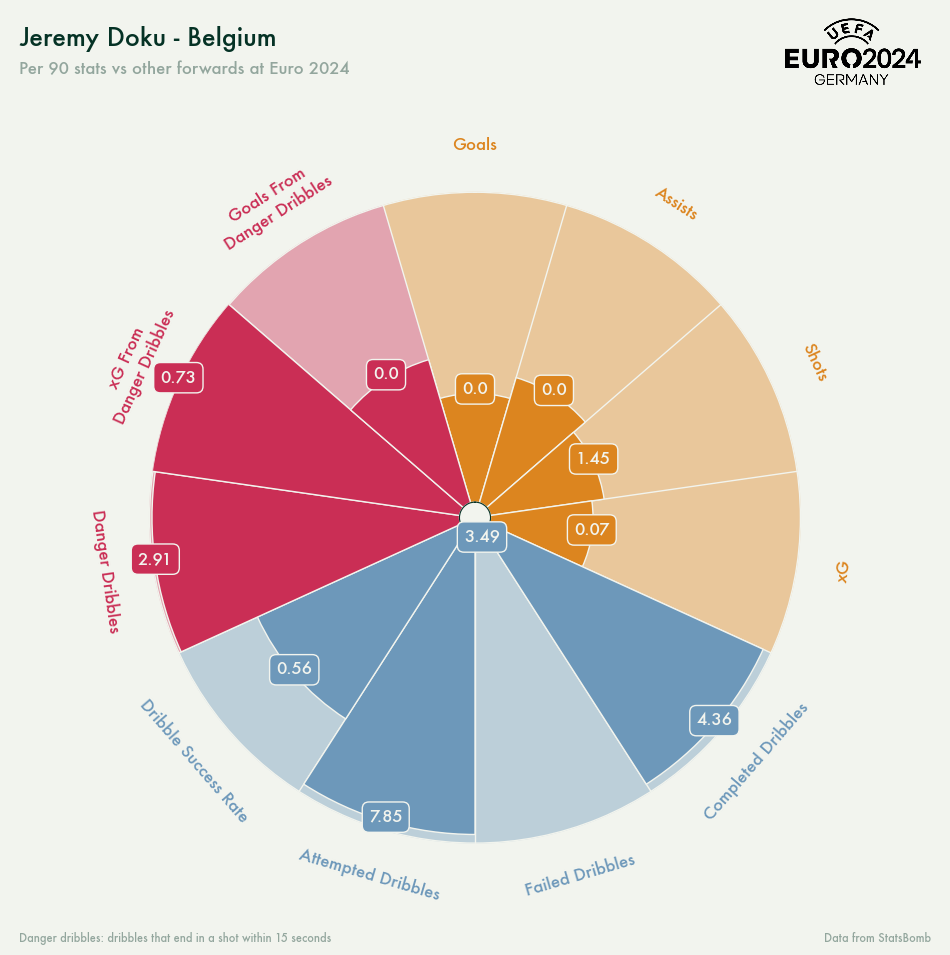

In [479]:
# Set up plot
fig, heading_ax, main_ax, legend_ax = setup_plot()


# HEADING
heading_ax.text(0.01, 0.8, 'Jeremy Doku - Belgium', fontweight='bold', fontsize=h1_size, ha='left', va='center')
heading_ax.text(0.01, 0.55, 'Per 90 stats vs other forwards at Euro 2024', fontsize=p_size, ha='left', va='center', alpha=alpha)

# Add Euros 2024 logo
logo = mpimg.imread('euro_2024_logo.png')
imagebox = OffsetImage(logo, zoom=0.2)
ab = AnnotationBbox(imagebox, (0.98, 0.7), xycoords='axes fraction', box_alignment=(1, 0.5), frameon=False)
heading_ax.add_artist(ab)


# MAIN
params = [
    "Goals", "Assists", "Shots", "xG",
    "Completed Dribbles", "Failed Dribbles", "Attempted Dribbles", "Dribble Success Rate",
    "Danger Dribbles", "xG From\nDanger Dribbles", "Goals From\nDanger Dribbles"
]

slice_colors = [general_stats_color] * 4 + [dribble_stats_color] * 4 + [danger_dribble_stats_color] * 3
params_colors = [general_stats_color] * 4 + [dribble_stats_color] * 4 + [danger_dribble_stats_color] * 3

# Init PyPizza class
baker = PyPizza(
    params=params,                          # List of parameters
    background_color=background_color,      # Background color
    straight_line_color=background_color,   # Lines between slices
    straight_line_lw=1,                     # Linewidth for straight lines
    last_circle_color=background_color,     # Color for last circle
    last_circle_lw=2,                       # Linewidth of last circle
    other_circle_lw=0,                      # Linewidth for other circles
    inner_circle_size=5,                    # Size of inner circle
)

# Plot pizza
baker.make_pizza(
    doku_percentiles,                       # List of values
    ax=main_ax,
    param_location=115,
    color_blank_space="same",               # Color to fill blank space of slices
    blank_alpha=0.4,                        # Alpha for blank-space colors
    slice_colors=slice_colors,              # Color for individual slices
    value_bck_colors=slice_colors,          # Background color for the values box
    kwargs_params=dict(                     # Labels of slices on the outside of the pizza                 
        fontsize=p_size,                    
        va="center",                        
    ),
    kwargs_slices=dict(                     # Edges of slices
        edgecolor=background_color, 
        zorder=2, 
        linewidth=1
    ),
    kwargs_values=dict(                     # Values box
        color=background_color, 
        fontsize=p_size, 
        zorder=3,
        bbox=dict(
            edgecolor=background_color, 
            facecolor=background_color,
            boxstyle="round,pad=0.4", 
            lw=1
        )
    )
)

# Replace slice text with actual values (normally shows percentiles)
texts = baker.get_value_texts()
for i, text in enumerate(texts):
    text.set_text(str(doku_values[i]))

# Set param label colors individually
param_texts = baker.get_param_texts()
for i, text in enumerate(param_texts):
    text.set_color(params_colors[i])


# LEGEND
legend_ax.text(0.01, 0.01, 'Danger dribbles: dribbles that end in a shot within 15 seconds', fontsize=label_size, ha='left', va='center', alpha=alpha)
legend_ax.text(0.99, 0.01, 'Data from StatsBomb', fontsize=label_size, ha='right', va='center', alpha=alpha)

# Save and show plot
save_plot(fig, 'radar_doku.png')
plt.show()

In [480]:
df_forwards_stats.sort_values(by="failed_dribbles_per90", ascending=False).head(10)

,player_id,player_name,player_short_name,team_name,positions,playing_time,goals,assists,shots,shots_xg,...,goals_per90,assists_per90,shots_per90,shots_xg_per90,completed_dribbles_per90,failed_dribbles_per90,attempted_dribbles_per90,danger_dribbles_per90,danger_dribbles_xg_per90,dribbles_to_goals_per90
604,163610,Leo Sauer,Leo Sauer,Slovakia,"{17, 21}",576,0,0,0,0.000000,...,0.000000,0.000000,0.000000,0.000000,9.375000,9.375000,18.750000,0.000000,0.000000,0.000000
596,143864,Fermin Lopez Marin,Fermín López,Spain,"{19, 21}",2004,0,0,2,0.038077,...,0.000000,0.000000,5.389222,0.102602,2.694611,5.389222,8.083832,0.000000,0.000000,0.000000
267,12306,Dodi Lukebakio,Dodi Lukebakio,Belgium,"{17, 2, 7}",4310,0,0,3,0.122858,...,0.000000,0.000000,3.758701,0.153928,2.505800,5.011601,7.517401,0.000000,0.000000,0.000000
218,9640,Jarrod Bowen,Jarrod Bowen,England,"{17, 12, 21}",2633,0,0,0,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,4.101785,4.101785,0.000000,0.000000,0.000000
387,28239,Adam Hložek,Adam Hložek,Czech Republic,"{20, 13}",5791,0,0,4,0.489691,...,0.000000,0.000000,3.729926,0.456627,0.000000,3.729926,3.729926,0.000000,0.000000,0.000000
473,38229,Khvicha Kvaratskhelia,Kvara,Georgia,"{16, 21, 24}",20808,1,0,6,0.552086,...,0.259516,0.000000,1.557093,0.143275,3.633218,3.633218,7.266436,0.259516,0.013156,0.000000
361,23650,Jeremy Doku,Jérémy Doku,Belgium,"{16, 17, 21}",18580,0,0,5,0.255422,...,0.000000,0.000000,1.453175,0.074235,4.359526,3.487621,7.847147,2.906351,0.725415,0.000000
263,12041,João Félix Sequeira,João Félix,Portugal,"{16, 20}",6697,0,0,5,0.964703,...,0.000000,0.000000,4.031656,0.777870,1.612662,3.225325,4.837987,0.806331,0.028802,0.000000
560,68574,Nicholas Williams Arthuer,Nico Williams,Spain,{21},29135,2,1,12,0.948560,...,0.370688,0.185344,2.224129,0.175810,2.780161,3.150849,5.931011,0.741376,0.099617,0.185344
481,39143,Matěj Jurásek,Matěj Jurásek,Czech Republic,"{8, 18}",3470,0,0,4,0.098756,...,0.000000,0.000000,6.224784,0.153684,6.224784,3.112392,9.337176,0.000000,0.000000,0.000000
